In [1]:
import pandas as pd

# Load the datasets
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
dev_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_dev.tsv'
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'

# Load TSV files into DataFrames
train_data = pd.read_csv(train_file_path, sep='\t')
dev_data = pd.read_csv(dev_file_path, sep='\t')
test_data = pd.read_csv(test_file_path, sep='\t')

# Display the first few rows of each dataset
train_data.head(), dev_data.head(), test_data.head()

(             event_name            tweet_id              image_id  \
 0  california_wildfires  917791291823591425  917791291823591425_0   
 1  california_wildfires  917791291823591425  917791291823591425_1   
 2  california_wildfires  917793137925459968  917793137925459968_0   
 3  california_wildfires  917793137925459968  917793137925459968_1   
 4  california_wildfires  917793137925459968  917793137925459968_2   
 
                                           tweet_text  \
 0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...   
 2  RT @KAKEnews: California wildfires destroy mor...   
 3  RT @KAKEnews: California wildfires destroy mor...   
 4  RT @KAKEnews: California wildfires destroy mor...   
 
                                                image            label  \
 0  data_image/california_wildfires/10_10_2017/917...      informative   
 1  data_image/california_wildfires/10_10_2017/917...  not_informative   
 2  data_ima

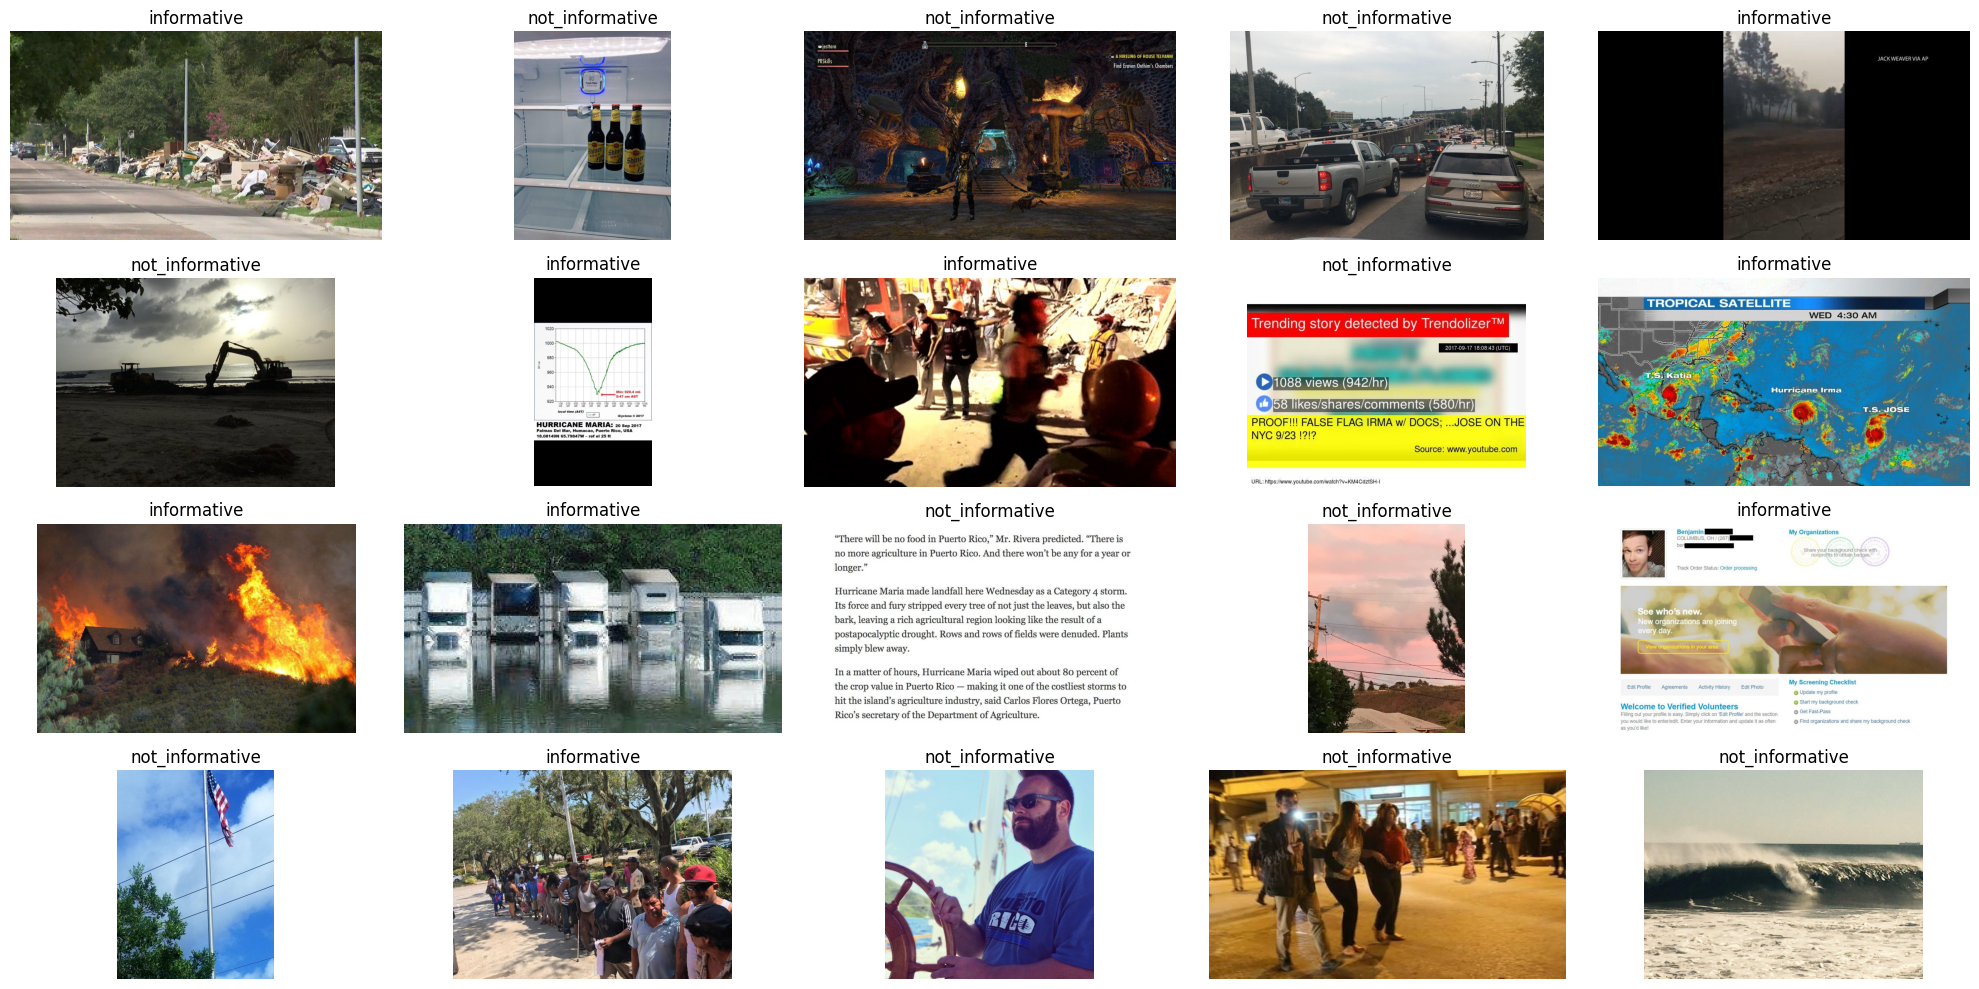

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

# Load the dataset
train_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv'
train_data = pd.read_csv(train_file_path, sep='\t')

# Randomly sample 20 rows from the dataset
random_sample = train_data.sample(n=20, random_state=42)

# Define a function to display images
def display_images(data, image_column, label_column, image_root_dir=''):
    plt.figure(figsize=(20, 10))
    for i, (_, row) in enumerate(data.iterrows()):
        image_path = row[image_column]
        label = row[label_column]
        try:
            # Open the image
            img = Image.open(image_root_dir + image_path)
            plt.subplot(4, 5, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(label)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
    plt.tight_layout()
    plt.show()

# Display 20 random images with labels
display_images(random_sample, 'image', 'label_image', image_root_dir='')


Some weights of ViTModel were not initialized from the model checkpoint at D:/BTP_2/CrisisMMD_v2.0/model_image and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/5, Loss: 441.4058, Accuracy: 0.8430


c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/5, Loss: 418.0881, Accuracy: 0.8479


c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/5, Loss: 415.3910, Accuracy: 0.8437


c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/5, Loss: 411.5327, Accuracy: 0.8510


c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/5, Loss: 411.6320, Accuracy: 0.8494


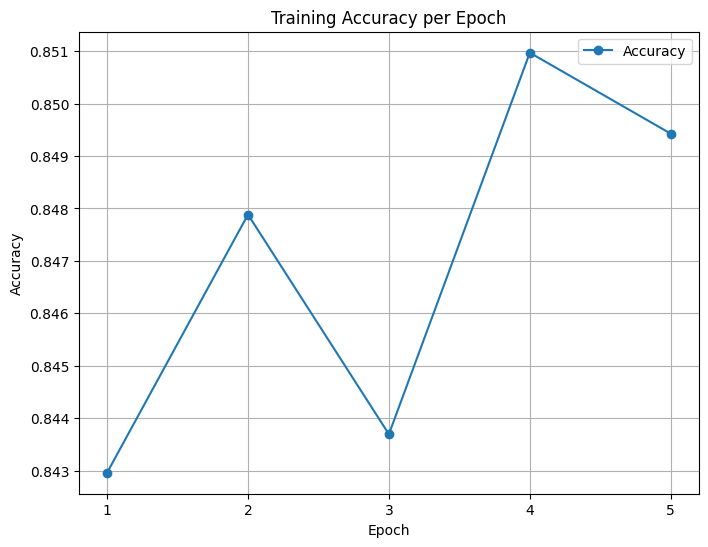

In [2]:
from transformers import AutoModel, AutoTokenizer, AutoFeatureExtractor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load saved models and processors
text_model_path = "D:/BTP_2/CrisisMMD_v2.0/model_text"
image_model_path = "D:/BTP_2/CrisisMMD_v2.0/model_image"

# Load the saved text model and tokenizer
modeltext = AutoModel.from_pretrained(text_model_path)
tokenizer = AutoTokenizer.from_pretrained(text_model_path)

# Load the saved image model and feature extractor
modelimage = AutoModel.from_pretrained(image_model_path)
feature_extractor = AutoFeatureExtractor.from_pretrained(image_model_path)

# Remove the last layers from modelimage and modeltext
modelimage.classifier = nn.Identity()  # Remove the classification layer of modelimage
modeltext.pooler = nn.Identity()  # Remove the pooler layer from modeltext (if exists)

# Freeze the parameters of modelimage and modeltext
for param in modelimage.parameters():
    param.requires_grad = False

for param in modeltext.parameters():
    param.requires_grad = False

# Define the combined model
class MultimodalClassifier(nn.Module):
    def __init__(self, text_model, image_model, hidden_size=512):
        super(MultimodalClassifier, self).__init__()
        self.text_model = text_model
        self.image_model = image_model
        
        # Fully connected layer for combining text and image features
        self.fc = nn.Sequential(
            nn.Linear(768 + 768, hidden_size),  # Combine text and image features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, 2)  # Final output layer for 2 classes (Positive/Negative)
        )

    def forward(self, input_ids, attention_mask, pixel_values):
        with torch.no_grad():  # Freeze the weights of pretrained models
            # Extract text embeddings (using the CLS token from last_hidden_state)
            text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
            text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token
            
            # Extract image embeddings (CLS token or alternative feature)
            image_outputs = self.image_model(pixel_values=pixel_values)
            image_features = image_outputs.last_hidden_state[:, 0, :]  # CLS token
        
        # Concatenate features
        combined_features = torch.cat((text_features, image_features), dim=1)
        # Pass through fully connected layer
        output = self.fc(combined_features)
        return output

# Initialize the combined model
model = MultimodalClassifier(text_model=modeltext, image_model=modelimage).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters(), lr=5e-4, weight_decay=0.01)

# Dataset class
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer, feature_extractor, image_dir):
        self.data = data
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.image_dir = image_dir

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        tweet_text = self.data.iloc[idx]['tweet_text']
        image_path = os.path.join(self.image_dir, self.data.iloc[idx]['image'])
        label = self.data.iloc[idx]['label']  

        # Tokenize text
        text_inputs = self.tokenizer(
            tweet_text,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        )

        # Open and process the image
        image = Image.open(image_path).convert("RGB")
        image_inputs = self.feature_extractor(
            images=image,
            return_tensors="pt"
        )

        return {
            "input_ids": text_inputs["input_ids"].squeeze(0),
            "attention_mask": text_inputs["attention_mask"].squeeze(0),
            "pixel_values": image_inputs["pixel_values"].squeeze(0),
            "label": torch.tensor(1 if label == 'informative' else 0, dtype=torch.long)
        }

# Load the TSV file
train_data = pd.read_csv('crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_train.tsv', delimiter='\t')

# Select only the relevant columns
train_data = train_data[['tweet_text', 'image', 'label']]

# Specify image directory
image_dir = ''  # Path to your image directory (make sure to specify this)

# Create dataset and dataloader
dataset = MultimodalDataset(train_data, tokenizer, feature_extractor, image_dir)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Training loop
num_epochs = 5
epoch_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for batch in train_dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    epoch_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.4f}")

# Plot accuracy for each epoch
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_accuracies, marker='o', label='Accuracy')
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xticks(range(1, num_epochs + 1))
plt.grid()
plt.legend()
plt.show()



c:\Users\Aman\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Test Accuracy: 0.7689
Classification Report:
                  precision    recall  f1-score   support

Non-Informative       0.66      0.81      0.73       864
    Informative       0.86      0.74      0.80      1373

       accuracy                           0.77      2237
      macro avg       0.76      0.78      0.76      2237
   weighted avg       0.79      0.77      0.77      2237



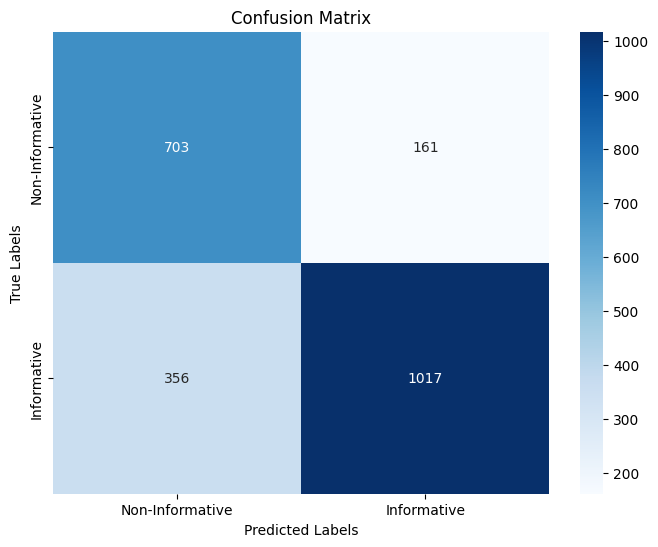

In [11]:
import torch
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the test data
test_file_path = 'crisismmd_datasplit_all/crisismmd_datasplit_all/task_informative_text_img_test.tsv'
test_data = pd.read_csv(test_file_path, delimiter='\t')

# Select only the relevant columns
test_data = test_data[['tweet_text', 'image', 'label']]

# Create a dataset and dataloader for testing
test_dataset = MultimodalDataset(test_data, tokenizer, feature_extractor, image_dir)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
preds, labels = evaluate_model(model, test_dataloader)

# Compute metrics
accuracy = accuracy_score(labels, preds)
report = classification_report(labels, preds, target_names=['Non-Informative', 'Informative'])
conf_matrix = confusion_matrix(labels, preds)

# Print the results
print(f"Test Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Informative', 'Informative'], yticklabels=['Non-Informative', 'Informative'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
